# Termination Condition Analysis

This notebook file contains our code related to the second analysis on an alternate termination condition. We changed the `run` method in the `MomentumGradientDescent` class so that we can do each iteration and validation error calculation outside of the `run` method.

In [1]:
import numpy as np

class MomentumGradientDescent:
    def __init__(
        self,
        learning_rate=0.001,
        momentum=0.9,
        max_iters=1e4,
        epsilon=1e-8,
        batch_size=32,
    ):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.prev_delta_w = None

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        term_cond = 0
        N, D = x.shape
        self.prev_delta_w = np.zeros(w.shape)

        for i in range(0, N, self.batch_size):
            if x.ndim == 1:
                batch_x = x[i:i + self.batch_size]
            else:
                batch_x = x[i:i + self.batch_size, :]
            if y.ndim == 1:
                batch_y = y[i:i + self.batch_size]
            else:
                batch_y = y[i:i + self.batch_size, :]
            # compute the gradient with present weight
            grad = gradient_fn(batch_x, batch_y, w)
            delta_w = self.get_delta_w(grad)
            # weight update step
            w = w - self.learning_rate * delta_w
        return w, grad

    def get_delta_w(self, grad):
        beta = self.momentum
        delta_w = beta * self.prev_delta_w + (1 - beta) * grad
        self.prev_delta_w = delta_w

        return delta_w

In [2]:
import numpy as np

# from the given Colab code
logistic = lambda z: 1./ (1 + np.exp(-z))  

class SoftmaxRegression:

    def __init__(self, add_bias=True, regularization_penalty=0.):
        self.add_bias = add_bias
        self.regularization_penalty = regularization_penalty
            
    def fit(self, x, y, C, optimizer, w0):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        
        def to_onehot(a):
            return np.eye(C)[a]
        
        def gradient(x, y, w):
            N, D = x.shape
            # yh: N x C
            yh = self.softmax(np.dot(x, w))
            # both are N x C
            yh = to_onehot(self.to_classlabel(yh))
            y = to_onehot(y)
            
            grad = np.dot(x.T, yh - y) / N
            if self.regularization_penalty > 0:
                if self.add_bias:
                    grad[:-1,:] += self.regularization_penalty * w[:-1,:]    # don't penalize the intercept
                else:
                    grad += self.regularization_penalty * w
            return grad
        
        # run the optimizer to get the optimal weights
        self.w, self.grad = optimizer.run(gradient, x, y, w0) 
        return self
    
    def softmax(self, z):
        # to prevent overflow/underflow
        z = z - np.max(z, axis=-1, keepdims=True)
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def to_classlabel(self, z):
        return z.argmax(axis=1)
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        # convert from 1D to 2D
        x = np.reshape(x, (1, -1))
        yh = self.softmax(np.dot(x, self.w))
        return self.to_classlabel(yh)[0]
        

# Validation of Model

Here we define the same `k_fold_splitter` method to perform K-fold cross-validation, and we define a new `termination_model_accuracy` method that returns the model with best accuracy once the validation error has not decreased for T consecutive iterations.

In [5]:
import math

def k_fold_splitter(fold, dataset):
    """
    Returns 2 datasets (training and validation)
    """
    start = math.floor(fold*(dataset.shape[0]/5))
    end = math.floor((fold+1)*(dataset.shape[0]/5))

    training = np.delete(dataset, slice(start, end-1), axis=0)
    validation = dataset[start:end-1]

    return training, validation

def termination_model_accuracy(x, y, C, learning_rate, momentum, batch_size, term_condition, max_iters=1000):
    """
    Calculate max accuracy of each iteration to see if we've reached a termination condition
    """
    j = 0
    T = 0
    N, D = x.shape
    prev_weight = np.random.rand(D,C)
    prev_accuracy = 0.00
    grad = np.inf
    epsilon = 1e-8
    
    # Ensure that: grad is non-zero, we have not reached max iterations and that our 
    # termination condition hasn't been reached
    while np.linalg.norm(grad) > epsilon and j < max_iters and T < term_condition:
        accuracies = []
        for fold_num in range(5):
            train_data, validation_data = k_fold_splitter(fold_num, x)
            train_labels, validation_labels = k_fold_splitter(fold_num, y)
            optimizer = MomentumGradientDescent(
                learning_rate=learning_rate, 
                momentum=momentum, 
                batch_size=batch_size, 
                max_iters=max_iters,
            )
            model = SoftmaxRegression(add_bias=False)

            model.fit(train_data, train_labels, C, optimizer, prev_weight)
            prev_weight = model.w
            grad = model.grad

            num_misclassified = 0
            # calculate the accuracy
            for i in range(len(validation_data)):
                prediction = model.predict(validation_data[i, :])
                if prediction != validation_labels[i]:
                    num_misclassified += 1
            misclassification_rate = num_misclassified / len(validation_labels)
            accuracies.append(1 - misclassification_rate)

        cur_accuracy = np.average(accuracies)
        
        if cur_accuracy > prev_accuracy:
            prev_accuracy = cur_accuracy
            T = 0
        else:
            T += 1
        j += 1

    return prev_accuracy


# Analysis

Below we analyze how different values of T for the termination condition affect the accuracy of our model. We do this for both datasets.

In [4]:
# store hyper-parameter values here for use below
digits_learning_rate = 0.14003
digits_momentum = 0.99
digits_batch_size = 897

wine_learning_rate = 0.14003
wine_momentum = 0.696
wine_batch_size = 178

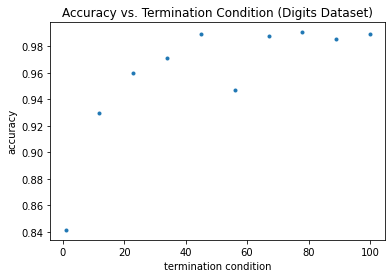

In [6]:
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
%matplotlib inline
import matplotlib.pyplot as plt

digits = load_digits()
x, y = digits.data, digits.target

C = 10
digits_accuracies = []
term_conditions = np.linspace(1, 100, 10)

for term_condition in term_conditions:
    # using the hyper-parameter values obtained from grid search
    accuracy = termination_model_accuracy(x, y, C, digits_learning_rate, digits_momentum, digits_batch_size, term_condition)
    digits_accuracies.append(accuracy)

# plot for accuracy vs. termination condition on digits dataset
plt.plot(term_condtions, digits_accuracies, '.')
plt.title('Accuracy vs. Termination Condition (Digits Dataset)')
plt.xlabel('termination condition')
plt.ylabel('accuracy')
plt.show()

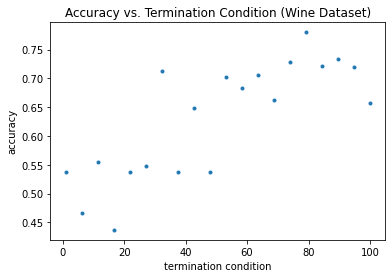

In [9]:
wine = load_wine()
x, y = wine.data, wine.target

C = 3
wine_accuracies = []
term_conditions = np.linspace(1, 100, 20)

for term_condition in term_conditions:
    # using the hyper-parameter values obtained from grid search
    accuracy = termination_model_accuracy(x, y, C, wine_learning_rate, wine_momentum, wine_batch_size, term_condition)
    wine_accuracies.append(accuracy)

# plot for accuracy vs. termination condition on wine dataset
plt.plot(term_condtions, wine_accuracies, '.')
plt.title('Accuracy vs. Termination Condition (Wine Dataset)')
plt.xlabel('termination condition')
plt.ylabel('accuracy')
plt.show()